# Quantum Computing in the Dominating Set Problem. Solution with QAOA

## Prerequisites

Here we imported all modules neeeded and construct the Graph class for drawing puctures and using in the working model 

In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from typing import Any, Dict, List, Tuple
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
print('Modules imported successfully!')

Modules imported successfully!


In [2]:
# Firstly, we define a class we can draw a graph in convinient way
class GraphModel:
    
    n_nodes: int
    edges: List[Tuple[int, int]]
    graph: nx.Graph
          
    def __init__(self, n_nodes, edges, qaoa_solve=None):
        
        self.n_nodes = n_nodes
        self.edges = edges
        self.graph = nx.Graph()
        self.graph.add_nodes_from(np.arange(0,n_nodes,1))
        self.graph.add_edges_from(edges)
        #self.qaoa_solve = qaoa_solve
        
    def draw_raw_graph(self):
        
        # Generate plot of the  Graph
        colors       = ['cornflowerblue' for node in self.graph.nodes()]
        default_axes = plt.axes(frameon=False)
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)

        nx.draw_networkx_nodes(self.graph, node_color=colors, node_size=900,pos = pos, 
                    alpha=1, ax=default_axes)       
        nx.draw_networkx_edges(self.graph, pos = pos, width=8,alpha=1,ax=default_axes,
                               edge_color="tab:gray")
        nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="white")

    def draw_done_graph(self,bitstring):
        
        # Draw a graph in accordance with its bitstring
        color_map = []
        edgelist_different  = []
        edgelist_same  = []
        default_axes = plt.axes(frameon=False)
        default_axes.axis('off')
        random_pos = nx.random_layout(self.graph, seed=42)
        pos = nx.spring_layout(self.graph, pos=random_pos)
        
        if bitstring == None:
            self.draw_raw_graph()
        else:
            for i in bitstring:
                if i > 0:
                    color_map.append('red')
                else: 
                    color_map.append('cornflowerblue')
#             for edge in self.edges:
#                 if bitstring[edge[0]] != bitstring[edge[1]]:
#                     edgelist_different.append(edge)
#                 else:
#                     edgelist_same.append(edge)
                    
            nx.draw_networkx_nodes(self.graph, node_color=color_map, node_size=900,pos = pos, 
                    alpha=1, ax=default_axes)       
            nx.draw_networkx_edges(self.graph, pos = pos, edgelist = self.edges, 
                                   width=8,alpha=1,ax=default_axes,edge_color="tab:grey")
#             nx.draw_networkx_edges(self.graph, pos = pos, edgelist = edgelist_different,
#                                    width=8,alpha=1,ax=default_axes, edge_color="tab:red")
            nx.draw_networkx_labels(self.graph, pos = pos, font_size=22, font_color="white")
    
    def connections(self, node): 
        connection_list = []
        for edge in self.edges:
                if (edge[0] == node):
                    connection_list.append(edge[1])
                elif (edge[1] == node):
                    connection_list.append(edge[0])
        connection_list = list(dict.fromkeys(connection_list))
        return connection_list

In [3]:
def graph_drawing(G,regime, *args, **kwargs):
    bitstring = kwargs.get('bitstring', None)
    filename = kwargs.get('filename', None)
    figure, axes = plt.subplots(frameon=False)
    axes.axis('off')
    # Turn off tick labels
    req_dpi = 100 
    figure.set_size_inches(500 / float(req_dpi),  
                           500 / float(req_dpi)) 
    if regime == 'raw':
        G.draw_raw_graph()
    elif regime == 'done':
        G.draw_done_graph(bitstring)
    else:
        raise ValueError('Regime is wrong')
        
    figure.savefig(filename, format='png',
               transparent=True, dpi=req_dpi) 

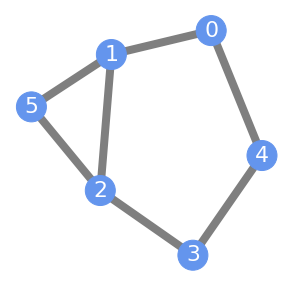

In [54]:
# Example of drawing method of the class GrapgModel
n_nodes = 6
E = [(0,1), (0,4),(1,2),(3,4), (3,2), (1,5), (1,0),(2,5) ]
G = GraphModel(n_nodes,E)
graph_drawing(G,'raw',filename = 'Complex_model11.png')

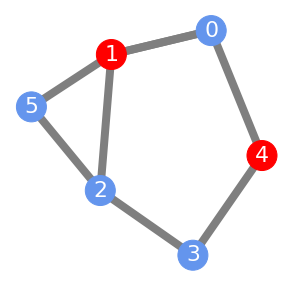

In [55]:
graph_drawing(G,'done',bitstring = [0,1,0,0,1,0],filename = 'graph_model22.png')

## Circuit constracion

The DSP solution with QAOA is made via maximization the cost fucntion $C(z) = \sum_{i=1}^{n-1}T_{i}(z) + D_{i}(z)$. Firtstly, we implement the circuit for $T_{k}(z)$

In [56]:
from qiskit.circuit.library import MCXGate
def create_cor(nqubits, theta):
    gate = MCXGate(nqubits-1) 
    
    qlist = [i for i in range(0,nqubits)]
    qr_cor = QuantumRegister(nqubits)
    cor_circuit = QuantumCircuit(qr_cor,name='ControlledOr2')
    
    for i in range(0, nqubits-1):
        cor_circuit.x(i)
    
#     cor_circuit.barrier()    
    cor_circuit.append(gate, qlist) 
    cor_circuit.rz(theta, nqubits-1)
    cor_circuit.append(gate, qlist)
#     cor_circuit.barrier()  
    
    for i in range(0, nqubits):
        cor_circuit.x(i)
        
    return cor_circuit  

[0, 1, 4, 6]
[0, 1, 2, 5, 6]
[1, 2, 3, 5, 6]
[2, 3, 4, 6]
[0, 3, 4, 6]
[1, 2, 5, 6]


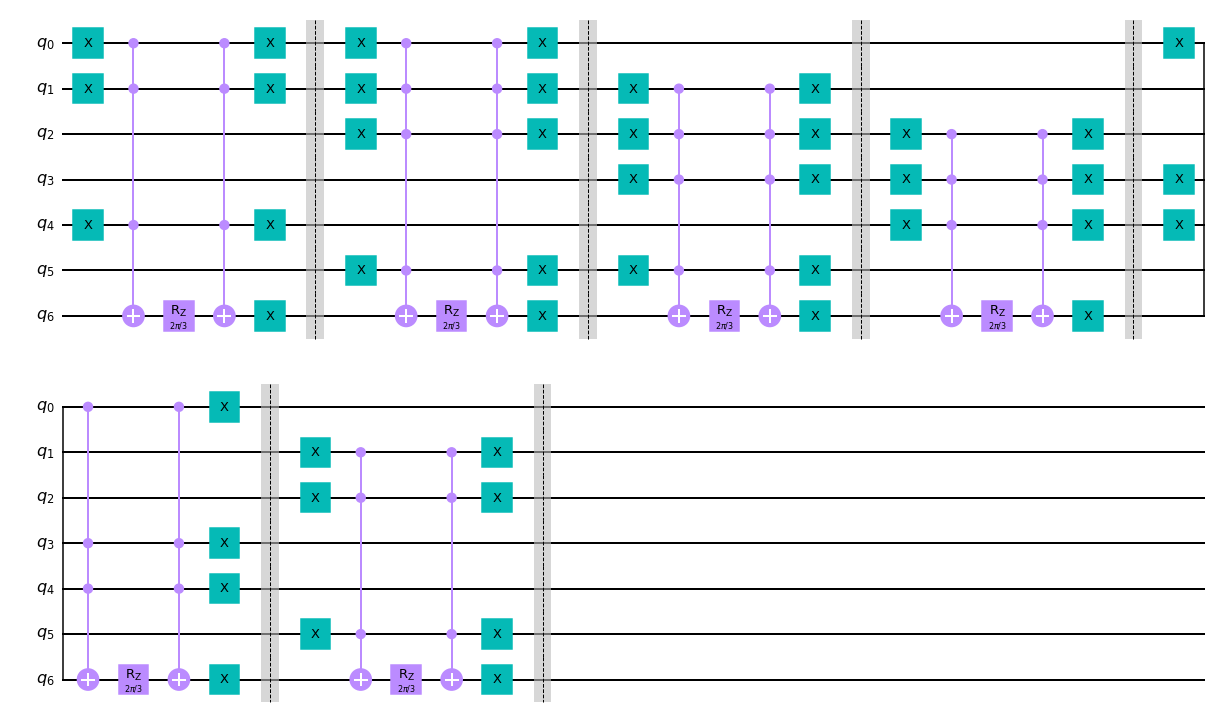

In [57]:
qc_part = QuantumCircuit(G.n_nodes+1)
theta = 2*np.pi/3 # to be removed afterwards
for node in range(0, G.n_nodes): #maxQubitNumber + 1 should be here
    cor_list = [node] + G.connections(node) + [G.n_nodes]
    cor_list.sort()
    cor = create_cor(len(cor_list),theta)
    print(cor_list)
    qc_part.append(cor, cor_list)
    qc_part.barrier()
qc_part.decompose().draw("mpl")

In [58]:
theta =  2*np.pi/3
def create_T_part(G,theta):
    qc_part = QuantumCircuit(G.n_nodes+1)
    for node in range(0, G.n_nodes): #maxQubitNumber + 1 should be here
        cor_list = [node] + G.connections(node) + [G.n_nodes]
        cor_list.sort()
        cor = create_cor(len(cor_list),theta)
#         print(cor_list)
        qc_part.append(cor, cor_list)
        qc_part.barrier()
    return qc_part

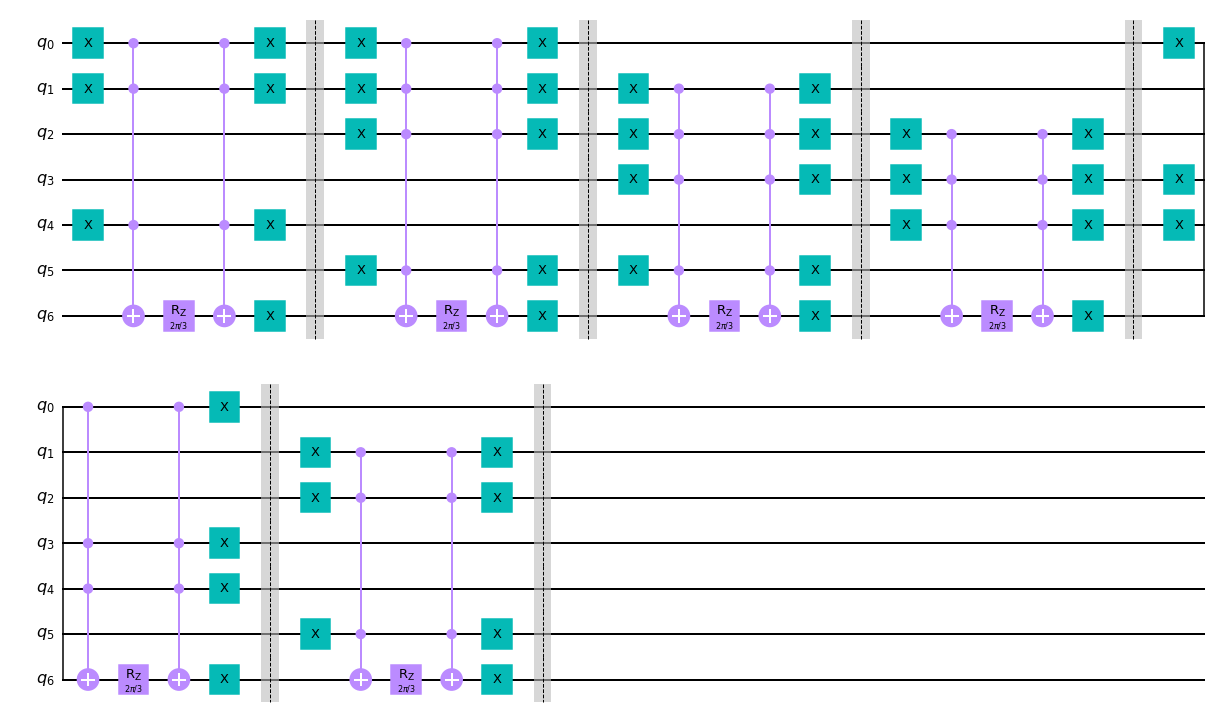

In [59]:
qc_part = create_T_part(G,theta)
qc_part.decompose().draw("mpl")

Now, we a ready to build the whole circuit, i.e. just add hadamard gates in the begining (excluding an auxiliary qubit), sequational control rotations($D$ part) and X-rotations like in every QAOA model.

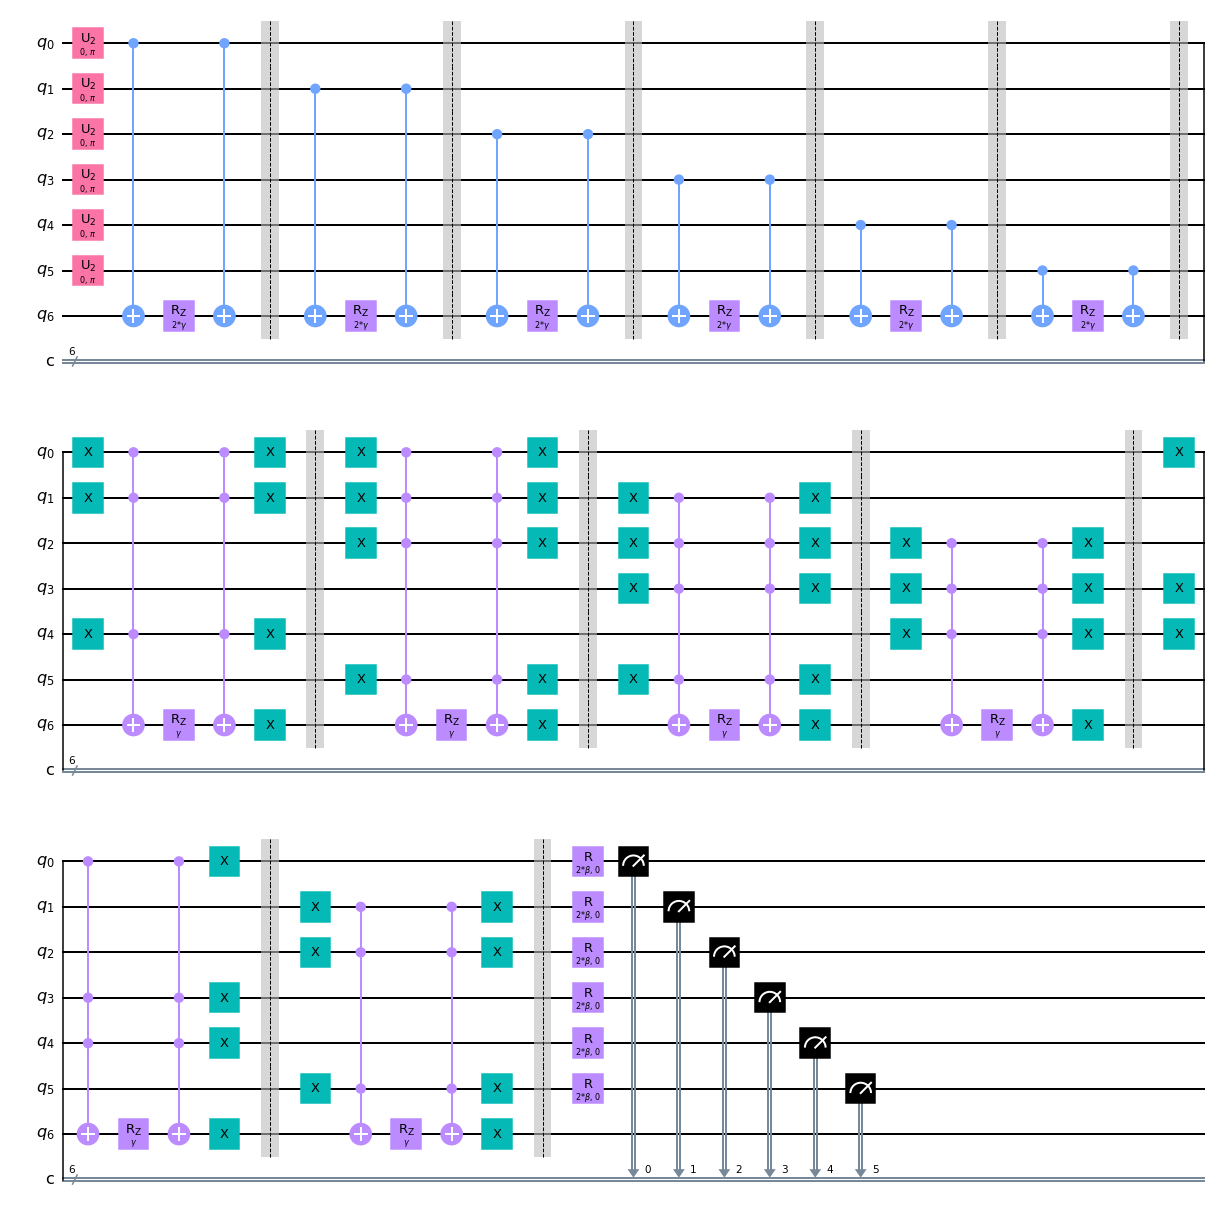

In [61]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(G.n_nodes)
for i in range(0, G.n_nodes):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_t = create_T_part(G,gamma)

qc_d = QuantumCircuit(G.n_nodes+1)
for i in range(0,G.n_nodes):
    qc_d.rzz(2 * gamma,i,G.n_nodes)
    qc_d.barrier()


qc_0 = QuantumCircuit(G.n_nodes+1)
for i in range(0, G.n_nodes):
    qc_0.h(i)

qc_qaoa = QuantumCircuit(G.n_nodes+1,G.n_nodes)

qc_qaoa.append(qc_0, [i for i in range(0, G.n_nodes+1)])
qc_qaoa.append(qc_d, [i for i in range(0, G.n_nodes+1)])
qc_qaoa.append(qc_t, [i for i in range(0, G.n_nodes+1)])
qc_qaoa.append(qc_mix, [i for i in range(0, G.n_nodes)])
qc_qaoa.measure([i for i in range(0, G.n_nodes)],[i for i in range(0, G.n_nodes)])
qc_qaoa.decompose().decompose().draw("mpl")

## Constructing the cost function

Having the previous part done, we can easily generalize our model for an arbitrary graph and define the cost function. As a consequence we will end with ready-to-use model of a given depth $p$. 

In [63]:
def T(G,k,z):
#   k is a node number, z is a bitstring  
    connection_list = G.connections(k)
    answer = 0
    for i in connection_list:
        if z[i] == 1: 
            answer = 1
    if z[k] == 1:
        answer = 1
        
    return answer

def D(k,z):
    
    answer = 0 
    if z[k]== 0:
        answer = 1
        
    return answer

In [65]:
def dsp_obj(bitstring, G):

#     Given a bitstring as a solution, this function returns
#     the number of edges shared between the two partitions
#     of the graph.

#     Args:
#         z: str
#            solution bitstring

#         G: networkx graph

#     Returns:
#         obj: float
#              Objective
    z = [int(x) for x in bitstring]
    obj = 0
    for k in range(0, G.n_nodes):
        obj -=  T(G,k,z) + D(k,z)
#     print("FOR ", z, " THE OBJECTIVE FUNCTION = ",obj)
    return obj


def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = dsp_obj(bitstring, G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function

def create_qaoa_circ(G, theta):

#     """
#     Creates a parametrized qaoa circuit

#     Args:  
#         G: networkx graph
#         theta: list
#                unitary parameters

#     Returns:
#         qc: qiskit circuit
#     """

    nqubits = G.n_nodes + 1
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits,nqubits-1)

    beta = theta[:p]
    gamma = theta[p:]
    print("Gamma = ", gamma)
    print("Beta = ", beta)
    # initial_state
    for i in range(0, nqubits-1):
        qc.h(i)

    for irep in range(0, p):   
            
        for i in range(0, G.n_nodes):
            qc_d.rzz(2 * gamma[irep], i, G.n_nodes)
            qc_d.barrier()    
            
        qc_t = create_T_part(G,gamma[irep])
        qc.append(qc_t, [i for i in range(0, G.n_nodes+1)])    
            
        for i in range(0, G.n_nodes):
            qc.rx(2 * beta[irep], i)
        qc_d.barrier()
    
    qc.measure([i for i in range(0, G.n_nodes)],[i for i in range(0, G.n_nodes)])    
    
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):

#         """
#         Runs parametrized circuit

#         Args:
#             G: networkx graph
#             p: int,
#                Number of repetitions of unitaries
#         """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        qc_res = transpile(qc, backend=backend, optimization_level=3)
        counts = backend.run(qc_res, seed_simulator=10, 
                             nshots=512).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ

def optimization(G,initial_parameters):
    expectation = get_expectation(G)

    res = minimize(expectation, initial_parameters, method='COBYLA')

    return res

Gamma =  [1.0]
Beta =  [1.0]


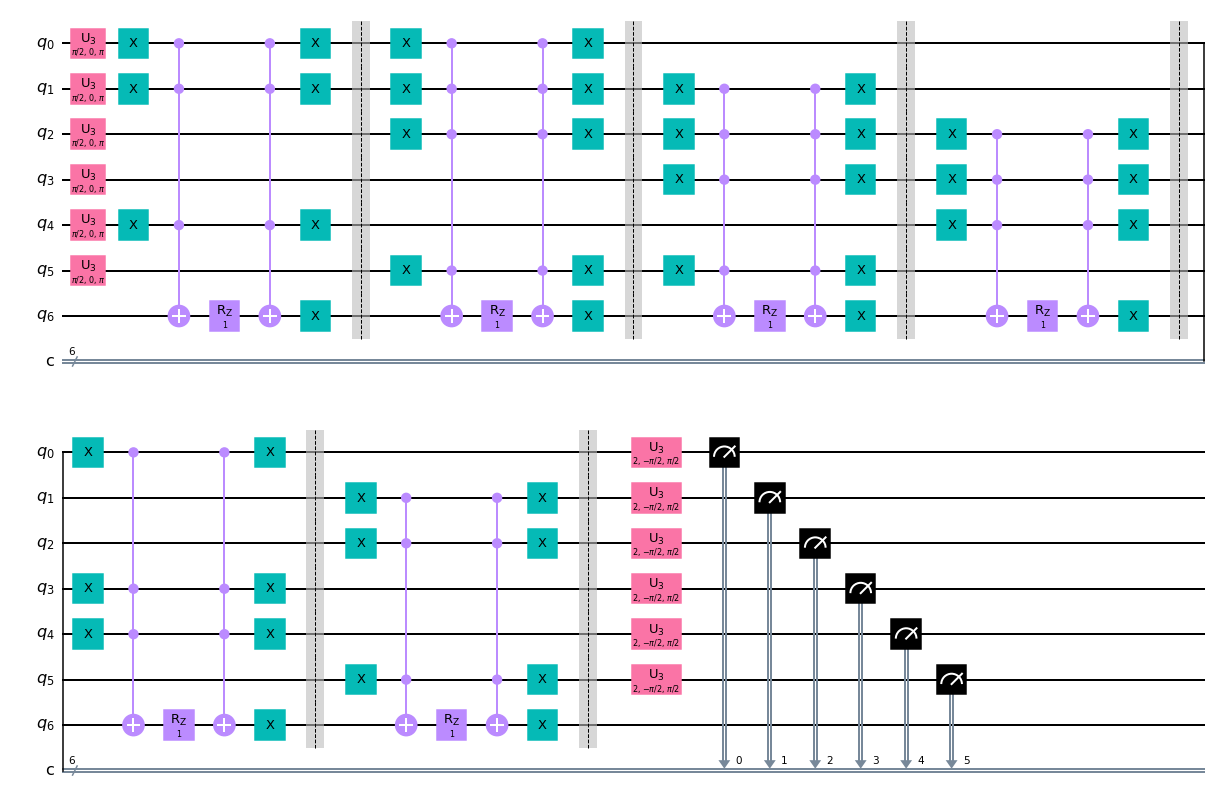

In [66]:
# Drawing circuit for p=1
initial_parameters = [1.0,1.0] * 1
qc_new = create_qaoa_circ(G, initial_parameters)
qc_new.decompose().decompose().draw("mpl")

## Working model and performance

Now it is posible to create the final QAOA class to work with and check the performance histogram.

In [67]:
class QAOA:
    counts: dict
    def __init__(self, graph, initial_parameters):
        self.graph = graph
        self.initial_parameters = initial_parameters
        
        backend = Aer.get_backend('aer_simulator')
        backend.shots = 512
#       qc_res = transpile(qc, backend=backend, optimization_level=3)
        qc_res = transpile(create_qaoa_circ(graph, optimization(graph,initial_parameters).x),
                           backend=backend, optimization_level=3)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        self.counts = counts
        
    def result(self):
        pass

In [72]:
# The parameter p here is circuit depth. We expect the performance of the model 
# would be better with p is ig enough
initial_parameters = [1.0,1.0]*12
model = QAOA(G,initial_parameters)
counts = model.counts

Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 1.]
Gamma =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Beta =  [2. 1. 2. 2. 1.

Gamma =  [1.04187654 1.03335362 1.04269381 1.01852606 2.04818117 0.99894923
 2.00062034 0.99768187 0.9996735  0.99947761 0.99771452 0.75806439]
Beta =  [1.99566244 0.93001588 1.95836151 2.02250912 1.04262445 0.979765
 0.99388089 0.54412995 1.30263162 1.02436368 1.02191188 1.01946008]
Gamma =  [1.17781103 1.12440911 1.17249767 1.04858269 2.20815635 0.99668155
 2.00156693 0.99414463 0.9991753  0.99868048 0.9942271  1.14027481]
Beta =  [2.0265407  0.7317032  1.8946369  1.98507955 1.16711492 0.85435366
 1.05189749 0.63047728 1.37333396 1.08000424 1.0485644  1.05776712]
Gamma =  [1.02178641 1.01940298 1.02201495 1.01525648 2.02354949 0.99970615
 2.00062034 1.17320042 0.9996735  0.99947761 0.81968857 0.99745333]
Beta =  [1.9910915  0.97877188 1.95819331 2.03116128 1.02295483 0.9912889
 0.9812759  0.53009521 1.29280202 1.01688896 1.01620332 1.01551767]
Gamma =  [1.0249608  1.02048863 1.02189259 1.01843217 2.0251998  1.00054304
 2.0009376  1.35049868 0.99950653 0.99921044 1.34875103 0.99228508

Gamma =  [1.09588517 1.08298137 1.09156297 1.02496788 2.08298999 1.00665781
 1.9956981  0.93720973 1.00980029 1.00860767 0.9516926  1.03520081]
Beta =  [2.02225851 0.97218628 1.89333734 1.96800935 1.06551228 1.03848914
 0.97827923 0.57454202 1.28587894 1.045342   1.07813858 1.03425555]
Gamma =  [1.07514284 1.0634056  1.06820903 0.99464272 2.05350695 1.00969058
 1.99409905 0.93354272 1.01350241 1.01182559 0.95311719 1.03773415]
Beta =  [2.03122414 0.9762925  1.88519416 1.96062838 1.07358038 1.03483046
 1.06581339 0.65280267 1.314924   0.99715016 1.07981355 1.00664414]
Gamma =  [1.08536445 1.07319351 1.08082034 1.0178694  2.07207878 1.00669009
 1.99570594 0.90555331 0.96686503 1.00855645 0.98429061 1.03463702]
Beta =  [2.02181657 0.97264424 1.89104049 1.96884158 1.0663972  1.03607921
 1.00852112 0.59450873 1.2971709  1.06922727 1.0415811  1.02704594]
Gamma =  [1.08891548 1.07615087 1.08321215 1.01222103 2.07115301 1.00842393
 1.99475322 0.99658882 0.92107586 1.01054131 0.88971408 1.03708

Gamma =  [1.12488417 1.15701953 1.070596   1.00640222 2.08546734 1.02180354
 1.99485957 0.93885719 0.97703651 0.98746176 0.96728191 1.04643058]
Beta =  [2.07306529 0.97724312 1.92486338 1.97062902 0.94466993 1.01543102
 1.06372463 0.60052584 1.22592405 1.07375698 1.04277055 1.00852854]
Gamma =  [1.12837247 1.16245576 1.08467077 0.99916561 2.0836396  0.97535585
 1.99786664 0.95390208 0.96202156 0.99483312 0.94982335 1.0092108 ]
Beta =  [2.07807068 0.9692641  1.92288054 1.96616556 0.95072702 1.0159698
 1.06393509 0.60708303 1.22799576 1.07969615 1.04172316 1.01212421]
Gamma =  [1.12370101 1.15567597 1.07250236 0.99184219 2.0808446  1.00566923
 1.98049695 0.929252   0.99196419 0.98808036 0.97698901 1.02994273]
Beta =  [2.07411193 0.9740199  1.92395965 1.96944906 0.9471566  1.0139838
 1.07455578 0.60992039 1.23003265 1.06047283 1.05021603 1.01793272]
Gamma =  [1.12116356 1.15614706 1.072757   1.0168732  2.07963197 1.00058726
 2.02911    0.93129243 0.99792158 0.99633866 0.97335923 1.0363796

Gamma =  [1.12320295 1.15649407 1.07761445 1.00447624 2.08761438 1.0006475
 1.99641158 0.93471613 0.98862975 0.98641795 0.97432121 1.02783391]
Beta =  [2.07024011 0.97153565 1.92573271 1.97278267 0.94450969 1.00592869
 1.06475052 0.5955676  1.22943537 1.07325896 1.04101116 1.01028182]
Gamma =  [1.12254599 1.15922562 1.07538008 1.00660937 2.08330061 1.00517525
 1.99538807 0.93073994 0.99310455 0.99186131 0.97600366 1.02947897]
Beta =  [2.07304882 0.97579547 1.92661508 1.97147165 0.94292451 1.01612007
 1.06505679 0.6000693  1.22514322 1.07410188 1.04247456 1.01048065]
Gamma =  [1.12583817 1.15484839 1.0710665  1.00868755 2.08197639 1.00513961
 1.99454231 0.93432667 0.98864389 0.98302503 0.98203602 1.02486216]
Beta =  [2.07335375 0.97980274 1.92780411 1.97208999 0.94629912 1.02055523
 1.06269718 0.59716535 1.22944617 1.07278855 1.04386826 1.00983816]
Gamma =  [1.12620793 1.15521006 1.0748457  1.00824603 2.08719198 1.00491167
 1.99472665 0.93234455 0.99185449 0.98828267 0.97872665 1.029532

Gamma =  [1.12681672 1.1579928  1.07499998 1.00614638 2.0843699  1.00531922
 1.99452353 0.92944494 0.99156445 0.9885159  0.97670604 1.02976443]
Beta =  [2.07261047 0.97401449 1.92519691 1.96996531 0.94603445 1.01522509
 1.0651068  0.60069384 1.2275172  1.07374349 1.04350882 1.00985797]
Gamma =  [1.12610436 1.15777438 1.07506071 1.00679246 2.08434677 1.00530122
 1.99517514 0.92992129 0.99175657 0.98821047 0.97661752 1.02983336]
Beta =  [2.07266267 0.973663   1.92497931 1.9706602  0.9467791  1.01505081
 1.06404838 0.60056857 1.22674406 1.07374188 1.04344224 1.00972582]
Gamma =  [1.1261833  1.15787217 1.07570612 1.00676668 2.08425093 1.0051926
 1.9952253  0.9296803  0.99198252 0.9883593  0.97682783 1.03009376]
Beta =  [2.073487   0.9739507  1.92467282 1.97056747 0.94607263 1.01529737
 1.06332306 0.60085295 1.22781962 1.07469596 1.04324557 1.00945831]
Gamma =  [1.12592464 1.15771027 1.07506645 1.00715627 2.08420487 1.00545354
 1.99516666 0.93006943 0.99182325 0.98826635 0.97669468 1.029642

Gamma =  [1.12622207 1.15773557 1.07536782 1.00664892 2.08406541 1.00520348
 1.99566186 0.92970897 0.99158492 0.98806782 0.97679916 1.02990036]
Beta =  [2.07308294 0.97391812 1.92486624 1.97042803 0.94617725 1.01500164
 1.06448725 0.60086076 1.22666786 1.07381981 1.04346484 1.00905492]
Gamma =  [1.12625667 1.15764328 1.07565126 1.00668031 2.08362494 1.00528007
 1.996189   0.92952383 0.99168998 0.98822346 0.97690071 1.03014863]
Beta =  [2.07339924 0.97393992 1.92452513 1.97013242 0.94622846 1.01570828
 1.06476003 0.60103216 1.2264101  1.07341928 1.04342467 1.00874644]
Gamma =  [1.12627697 1.15753287 1.07550717 1.00642778 2.08385393 1.00506553
 1.9962483  0.92972418 0.99155022 0.98808045 0.9769709  1.0301516 ]
Beta =  [2.07312785 0.97373102 1.92511299 1.97047044 0.9460489  1.01522179
 1.064685   0.60119544 1.22663512 1.07352683 1.04341071 1.0086209 ]
Gamma =  [1.12636209 1.1576422  1.07557003 1.0064706  2.08399167 1.00513982
 1.9962132  0.92963217 0.99164457 0.98809625 0.97696    1.03015

Gamma =  [1.12639021 1.15767337 1.07558283 1.00646178 2.08392269 1.0051055
 1.99620078 0.9296684  0.99156479 0.98805715 0.97691523 1.03009181]
Beta =  [2.07310578 0.97395662 1.92485694 1.97055504 0.94614903 1.01515301
 1.06469729 0.6011091  1.22649968 1.0735091  1.04354191 1.00861729]
Gamma =  [1.12640031 1.15768207 1.07557561 1.00646391 2.08390357 1.00512537
 1.99620415 0.92965186 0.99157202 0.9880803  0.97691293 1.03009371]
Beta =  [2.07312584 0.97394807 1.92483523 1.97050777 0.94616764 1.0152307
 1.06471639 0.60109969 1.22650108 1.07351116 1.04353689 1.00864126]
Gamma =  [1.12639125 1.15769041 1.0755693  1.00645168 2.08391289 1.00512245
 1.99620648 0.92964907 0.99157349 0.98808612 0.97690549 1.0300884 ]
Beta =  [2.07313236 0.97394477 1.92484162 1.97049801 0.94615319 1.01523798
 1.06469983 0.60108869 1.2264976  1.07351536 1.04356476 1.00862458]
Gamma =  [1.12639782 1.15769676 1.07560562 1.00645131 2.08391742 1.00512437
 1.9962344  0.92964326 0.99155445 0.98808808 0.97686814 1.0300711

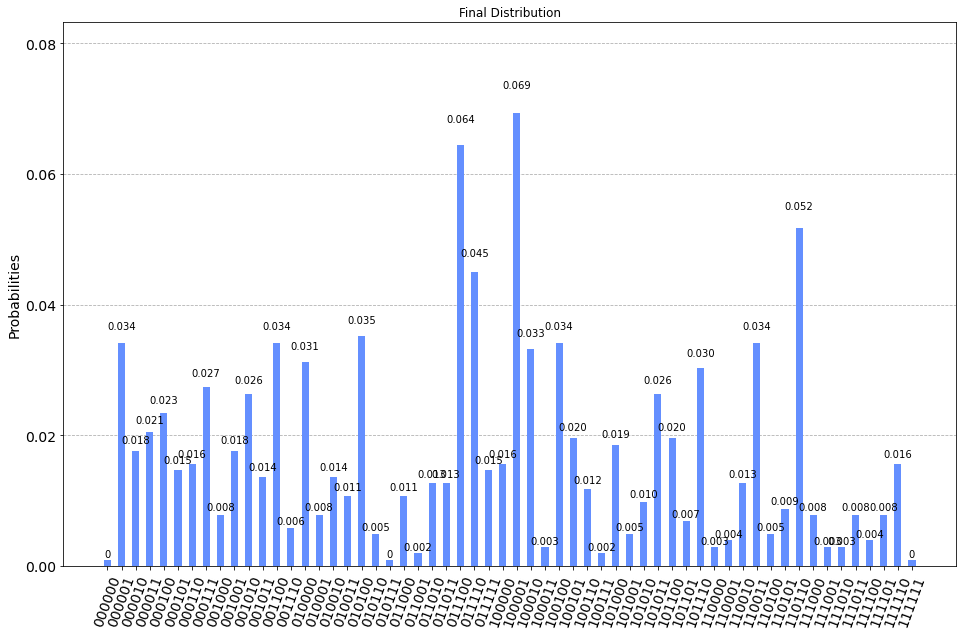

In [73]:
plot_histogram(counts, figsize=(16, 10), color=None, number_to_keep=None,
               sort='asc', target_string=None, legend=None,
               bar_labels=True, title="Final Distribution", ax=None)

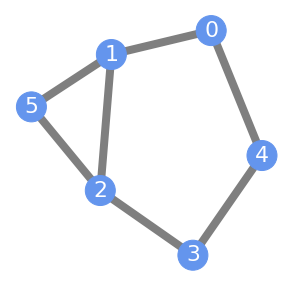

In [52]:
n_nodes = 6
E = [(0,1), (0,4),(1,2),(3,4), (3,2), (1,5), (1,0),(2,5) ]
G = GraphModel(n_nodes,E)
graph_drawing(G,'raw',filename = 'Complex_model11.png')

In [53]:
initial_parameters = [1.0,1.0]*5
model = QAOA(G,initial_parameters)
counts = model.counts

Gamma =  [1. 1. 1. 1. 1.]
Beta =  [1. 1. 1. 1. 1.]


CircuitError: 'Index out of range.'